In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for analytical solutions
import scipy
from scipy import optimize
from scipy.special import erfc as erfc
import math
from math import pi
from matplotlib import rc
import matplotlib.ticker as mtick
from labellines import labelLine, labelLines
rc('font',**{'family':'serif','serif':['Arial']})
plt.rcParams['font.size'] = 16
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.offsetbox import AnchoredText


In [2]:
def conc_star(conc_pfas, anion, cation): 
    I = 0.5*(conc_pfas/1000 + anion/1000 + cation/1000) # - Ionic strength calculations are in molarity
    logy = (0.507*np.sqrt(I))/(1+np.sqrt(I))+0.1*I #activity
    y = 10**(-logy)
    conc_star = np.sqrt((y*(conc_pfas+cation))*(y*conc_pfas)) #C*
    return conc_star

In [3]:
def langmuir_kaw(T_max, a, conc_star, conc):
    surf_ex = (T_max*a*conc_star)/(1 + a*conc_star)
    kaw = surf_ex/conc
    return surf_ex, kaw

In [4]:
def freundlich(k, n, conc_star, conc):
    surf_ex = k*conc_star**n
    kaw = surf_ex/conc
    return surf_ex, kaw

In [5]:
def Sw_func(a, n, Pc, Sr):
    m = 1 - (1/n)
    Sw = Sr+(1-Sr)*(1+(a*Pc)**n)**-m
    return Sw

In [6]:
def Pc_func(a, m, Sw, Sr):
    Seff = (Sw - Sr)/(1 - Sr)
    #n = 1 / (1-m)
    Pc = (1/a)*(Seff**(-1/m)-1)**(1-m)
    return Pc

In [7]:
def vadoseRetaration_profile_func(av, nv, Sr, Pc, s, U, phi, rhob, kaw, koc, foc, km):
    #units
    #Pc in kPa
    #av in 1/kPa
    #s in 1/cm
    #rhob in kg/L or g/cm3
    #kaw in cm
    #koc in L/kg
    #km in L/kg
    
    #saturation from Van Genucten (1980)
    #from 10.2136/sssaj1980.03615995004400050002x
    mv = 1 - (1/nv)   
    Sw = Sr+(1-Sr)*(1+(av*Pc)**nv)**-mv #change with thermo appraoch 
    
    #Awi calulations
    a = 14.3*np.log(U)+3.72
    m = 1.2 # currently only valid for U>3.5
    # m = -0.098*U+1.53 #for U<3.5
    n = 1/(2-m)
    Aia = s*(1+(a*(Sr+(1-Sr)*(Sw))**n))**-m  
    R_aw = kaw * Aia/(Sw*phi)
    Raw_tot = 1 + R_aw
    #solid-phase
    kd_oc = koc*foc
    R_oc = (kd_oc *rhob/(Sw*phi)) #OC component
    R_m = (km *rhob/(Sw*phi)) #mineral component
    R_sp = R_m + R_oc
    Rsp_tot = 1+ R_sp
    R_total = 1 + R_aw + R_sp #combined retardation
    
    return R_total, Raw_tot, Rsp_tot

In [10]:
#Site Specific Parameters=================================================================================
Sr_ORA = 0.05 #residual
Pc_kpa = np.linspace(0, 30, 100) #approimate capillary pressure range from measured SWCC
density = 1 #desity of water g/cm3
haw = (Pc_kpa / 9.81*density)*100 #height above water table [cm]

n_val = 4.0 #pore-size distribution
RH_U = 4.99#5.08 #uniformity coefficent
BET = 5 #spefici surface area in m2/g
phi = 0.42 #porosity
rhob = 1.53 #averaged dry bulk density?? <--- use this
s = (BET*100**2)*rhob #specific surface area in 1/cm
OC_dis = (1*10**-6)*np.exp(0.3621*(Pc_kpa)) #distribution of organic carbon

#PFAS solid-phase sorption 
#PFOS=================================================================================================
pfos_koc = (10**3.41) #averaged lit values for     alt literature values for PFOS (2.8)
pfos_km = 0.1 #calculated Kd from LCMS - assumed completely associated with mineral phase adsorption
pfos_km_nacl = 0.34
#PFHxS==============================================================================================
pfhxs_koc = (10**2.71) #averaged lit values for

#PFOA=============================================================================================
pfoa_koc = (10**2.62) #averaged lit values for

#PFDA=============================================================================================
pfda_koc = (10**3.65) #averaged lit values for

#================================================================================================

a_sand = 0.25 #entry pressure of 4 kPa -GRAVELY SAND #formerly a_sand
a_fsand = 0.08 #sactually the fine-sand
a_silt = 0.055 #actually the silty-sand


#%%- 1d profiles
#PFOS=========================================================================================================
#gravely-sand
# R_pfos_gravels = vadoseRetaration_profile_func(a_sand, n_val, Sr_ORA, Pc_kpa, s, RH_U, 
#                                                            phi, rhob, pfos_kaw, pfos_koc, OC_dis, pfos_km)
# #fine-sand
# R_pfos_fine = vadoseRetaration_profile_func(a_fsand, n_val, Sr_ORA, Pc_kpa, s, RH_U, 
#                                                            phi, rhob, pfos_kaw, pfos_koc, OC_dis, pfos_km)
# #silty sand
# R_pfos_silt = vadoseRetaration_profile_func(a_silt, n_val, Sr_ORA, Pc_kpa, s, RH_U, 
#                                                            phi, rhob, pfos_kaw, pfos_koc, OC_dis, pfos_km)




In [12]:

#concentrations of interest
conc_range = np.array([0.00001, 0.01]) #mg/L -- 10ppt, 100ppt, 1ppb, 10 ppb
conc_text = np.array(['10 ng/L',' 10 ug/L'])


#PFOS==========================================================================================

pfos_mw = 538220 #mg/mol
pfos_conc = np.multiply(conc_range, 1000/pfos_mw) #mol/m3
pfos_star = conc_star(pfos_conc, 0, pfos_conc)
print(pfos_conc)
#langmuir Parameters
pfos_T_max = 3.08*10**-6
pfos_a = 6.36

#kaw estimate
#langmuir
pfos_se, pfos_kaw = langmuir_kaw(pfos_T_max, pfos_a, pfos_star, pfos_conc)

#freundlich
# pfos_se, pfos_kaw = freundlich(8.28E-06, 0.85, pfos_star, pfos_conc)
pfos_kaw = 100*pfos_kaw #cm
print(pfos_kaw) 

[1.85797629e-08 1.85797629e-05]
[0.00277026 0.00276937]


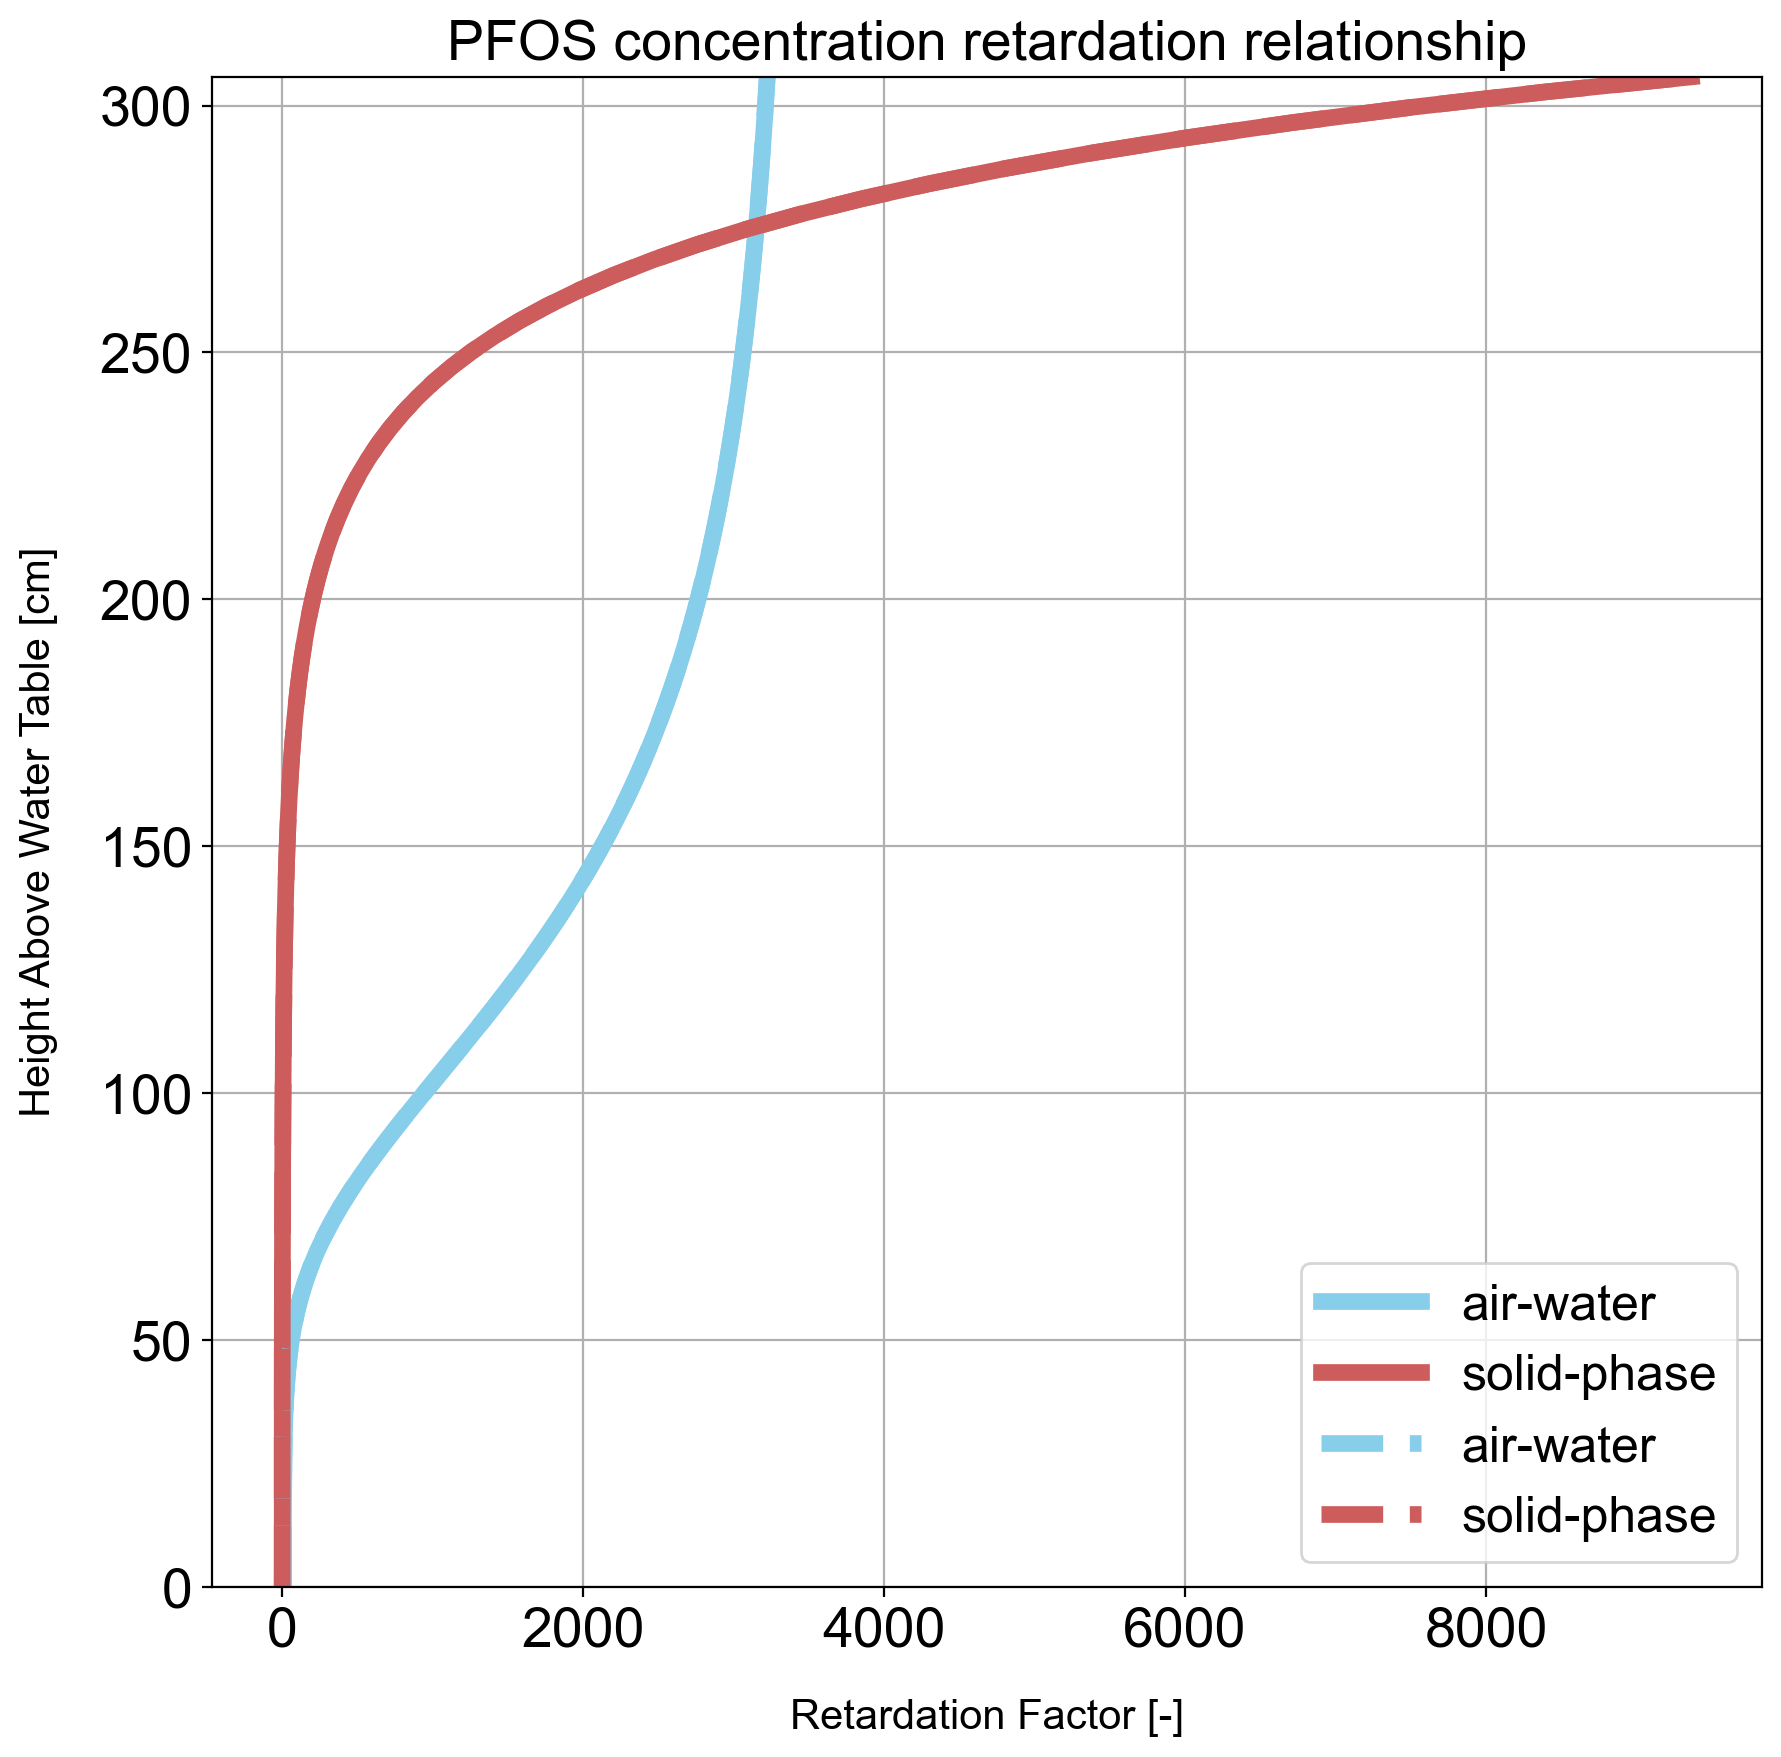

In [13]:
pfoacolors = plt.cm.Reds(np.linspace(0,1,5))
pfoscolors = plt.cm.Blues(np.linspace(0,1,5))
pfhxscolors = plt.cm.Greens(np.linspace(0,1,5))
pfdacolors = plt.cm.Purples(np.linspace(0,1,5))

fig_PFOS, (ax) = plt.subplots(1, 1, figsize=(10, 10), dpi=200)
lines = np.array(['-', '--', ])

for i in range(len(conc_range)):
    R_pfos_gravels = vadoseRetaration_profile_func(a_sand, n_val, Sr_ORA, Pc_kpa, s, RH_U, phi, rhob, pfos_kaw[i], pfos_koc, OC_dis, pfos_km)

    linwid = 6

#     ax.plot(R_pfos_gravels[0], haw, label = '{}'.format(conc_text[i]), linewidth = 6, c='mediumpurple', ls = lines[i])
    ax.plot(R_pfos_gravels[1], haw, label = 'air-water', linewidth = 6, c='skyblue', ls = lines[i]) #air_water
    ax.plot(R_pfos_gravels[2], haw, label = 'solid-phase', linewidth = 6, c='indianred', ls = lines[i]) #solid_phase


ax.set_ylabel('Height Above Water Table [cm]', fontsize = 15, labelpad=15)
ax.set_xlabel('Retardation Factor [-]', fontsize = 15, labelpad=15)
ax.set_title('PFOS concentration retardation relationship', fontsize = 20)
ax.set_ylim(0, max(haw))
# ax.set_xlim(-500, 10000)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.legend(loc = 4, prop={'size': 18})
ax.grid()